In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

In [117]:
aisles_df = pd.read_csv("data/aisles.csv")
departments_df = pd.read_csv("data/departments.csv")
products_df = pd.read_csv("data/products.csv")
orders_df = pd.read_csv("data/orders.csv")
prior_df = pd.read_csv("data/order_products__prior.csv")
train_df = pd.read_csv("data/order_products__train.csv")
products_df_merged = (products_df
                      .merge(departments_df, on="department_id")
                      .merge(aisles_df, on="aisle_id"))

In [3]:
prior_df = prior_df.merge(orders_df[['user_id', 'order_id']], on='order_id', how='left')

In [4]:
prior_df = prior_df.merge(products_df_merged[['product_id', 'aisle_id']], on='product_id', how='left')

In [152]:
user_aisles = prior_df[['user_id', 'order_id', 'aisle_id']]

In [153]:
aisle_proportions = user_aisles[['order_id', 'aisle_id']].drop_duplicates()

In [154]:
aisle_proportions = aisle_proportions.aisle_id.value_counts(sort=False) / aisle_proportions.order_id.nunique()

In [155]:
user_num_orders = user_aisles[['user_id', 'order_id']].drop_duplicates().groupby(['user_id']).agg('count')

In [156]:
user_num_orders = user_num_orders['order_id']

In [157]:
user_aisles = user_aisles.drop_duplicates()

In [158]:
user_aisles = user_aisles[['user_id', 'aisle_id']]

In [159]:
user_aisles['count'] = 1
user_aisles = user_aisles.groupby(['user_id', 'aisle_id']).agg('count')

In [160]:
user_aisles = user_aisles.reset_index()

In [161]:
user_aisles_pivoted = user_aisles.pivot(index='user_id', columns='aisle_id', values='count')

In [162]:
user_aisles_pivoted = user_aisles_pivoted.fillna(0)

In [140]:
#user_aisles_pivoted = user_aisles_pivoted + aisle_proportions

In [163]:
prior_strength = 1
user_aisles_pivoted = (user_aisles_pivoted + prior_strength * aisle_proportions).multiply(1.0 / (user_num_orders + prior_strength), axis=0)

In [164]:
user_aisles_pivoted = np.log(user_aisles_pivoted / (1 - user_aisles_pivoted))

In [20]:
uap_means = user_aisles_pivoted.mean(axis=0)
user_aisles_pivoted = user_aisles_pivoted.add(-uap_means, axis=1)

In [21]:
uap_user_means = user_aisles_pivoted.mean(axis=1)
user_aisles_pivoted = user_aisles_pivoted.add(-uap_user_means, axis=0)

In [25]:
uap_std = user_aisles_pivoted.std(axis=0)
user_aisles_pivoted = user_aisles_pivoted.multiply(1.0/uap_std, axis=1)

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
similarity_table = cosine_similarity(user_aisles_pivoted.values.T, user_aisles_pivoted.values.T)

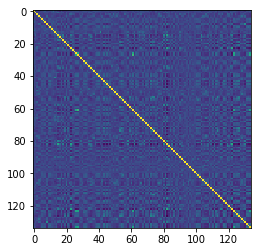

In [30]:
plt.imshow(similarity_table)

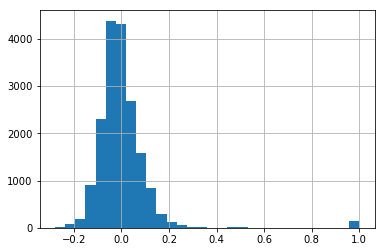

In [31]:
pd.Series([y for x in similarity_table for y in x]).hist(bins=30)

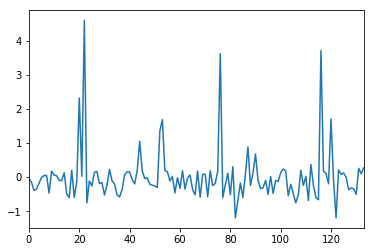

In [88]:
pd.Series(user_aisles_pivoted.values[0,:]).plot()

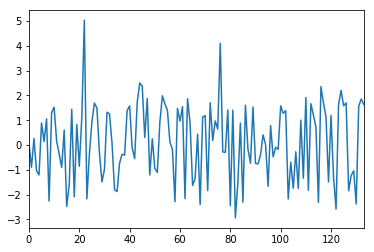

In [89]:
pd.Series(np.dot(similarity_table, user_aisles_pivoted.values[0,:])/np.linalg.norm(similarity_table, axis=1, ord=2)).plot()

In [99]:
user_aisles_pivoted.loc[:,:] = np.dot(user_aisles_pivoted.values, similarity_table)/np.linalg.norm(similarity_table, axis=1, ord=2)

In [100]:
user_aisles_pivoted = user_aisles_pivoted.multiply(uap_std, axis=1)
user_aisles_pivoted = user_aisles_pivoted.add(uap_user_means, axis=0)
user_aisles_pivoted = user_aisles_pivoted.add(uap_means, axis=1)

In [165]:
user_aisles_pivoted = 1.0/(1+np.exp(-user_aisles_pivoted))

In [166]:
user_aisle_probs = user_aisles_pivoted.reset_index().melt(id_vars='user_id')

In [167]:
data_df = prior_df[['user_id', 'product_id', 'aisle_id']].drop_duplicates()

In [168]:
data_df = data_df.merge(user_aisle_probs, on=['user_id', 'aisle_id'], how='left')

In [169]:
#train_df = train_df.merge(orders_df[['order_id', 'user_id']], on='order_id', how='left')

In [170]:
data_df = data_df.merge(train_df[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

In [171]:
data_df['reordered'] = data_df['reordered'].fillna(0)

In [172]:
from scipy.stats import pearsonr

In [174]:
pearsonr(data_df.value, data_df.reordered)

(0.15330651751908186, 0.0)